# Lab: Multi-modal and Multi-task
#### Mark Brubaker
*Some sections of this notbook were written with the aid of ChatGPT*

In [21]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

USE_SAVED_MODELS = True

In [22]:
import tensorflow as tf
from tensorflow import keras

# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  0
Num CPUs Available:  1
Tensorflow version: 2.10.0
Keras version: 2.10.0
No GPU found


## Give an overview of the dataset you have chosen to use

- *What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.*
- *Who collected the data? Why? When?*
- *What evaluation criteria will you be using and why?*

I will be performing classificagtion on a multi-modal dataset. The dataset is a collection of 6400 samples from 7 different gas-detecting sensors and a thermal imaging camera. The purpose of this dataset is to aid in the detection of gas leakages in different settings, such as chemical industries, coal mines, and home applications, among others. The dataset contains a total of 6,400 samples, with 1,600 samples per class for smoke, perfume, a mixture of smoke and perfume, and a neutral environment.

The low-cost sensors used in this dataset are generally less sensitive and reliable, and they are unable to detect gases from longer distances. To overcome this limitation, the thermal camera that senses temperature changes was also used in collecting the present multimodal dataset. This dataset is of significant importance to researchers and system developers interested in developing and training state-of-the-art artificial intelligence models and systems for gas detection purposes.

The data was collected by researches at Deemed University, India. The data was collected to help with the detection of gas leakages in different settings. The data was collected in 2022.

I will be using accuracy as my evaluation criteria. It works well for this dataset because each class is represented equally and have the same importance.

## How many tasks or modalities are there in the dataset and how do you define each task or modality?

*Explain if the task is within the same domain, cross domains, etc. If there are too many tasks or modalities to train the data reasonably, select a subset of the tasks for classification. For example, you might want to only train on 50 of the classification tasks.*

There are two modalities in this dataset. The first modality is the thermal camera, which is used to detect temperature changes. The second modality is the gas sensors, which are used to detect the presence of gases. The task is within the same domain, as the data is collected from the same setting. All seven sensors are of a similar type so I am treating them as one modality.

In [3]:
# group images from /data/Thermal Camera Images by class into folders

classes = ["NoGas", "Perfume", "Smoke", "Mixture"]
IMAGE_LENGTH = 640
IMAGE_WIDTH = 480

REORGANIZE_DATA = False

if REORGANIZE_DATA:
    for c in classes:
        if not os.path.exists("data/Thermal Camera Images/" + c):
            os.makedirs("data/Thermal Camera Images/" + c)

    # move images into folders
    # images follow the pattern: "#_class.png"

    # get all .png files in the directory
    files = os.listdir("data/Thermal Camera Images")
    png_files = [f for f in files if f.endswith(".png")]

    # move images into folders
    for f in png_files:
        # get the class of the image
        class_name = f.split("_")[1]
        # remove the .png extension
        class_name = class_name.split(".")[0]
        # move the image into the corresponding folder
        os.rename("data/Thermal Camera Images/" + f, "data/Thermal Camera Images/" + class_name + "/" + f)
        
# function that plots model history
def plot_history(history, name):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy %')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')

    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)

    plt.show()

In [4]:
class MultimodalDataset():
    def __init__(self, data, use_sensors=True, use_images=True):
        # filepaths = data['filepath']
        self.images = data['filepath'].values
        # MQ2 MQ3 MQ5 MQ6 MQ7 MQ8 MQ135
        self.sensor_data = data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']].values
        # Gas values
        self.classes = data['Gas'].values
        # if the number of unique classes is not 4, change some
        # this ensure that the dataset return the right sizes even if only a segment of the data is used by lying
        if len(np.unique(self.classes)) != 4:
            self.classes[0] = "Smoke"
            self.classes[1] = "Perfume"
            self.classes[2] = "Mixture"
            self.classes[3] = "NoGas"

        # Gas one-hot encoded
        cat = OneHotEncoder()
        self.labels = cat.fit_transform(self.classes.reshape(-1, 1)).toarray()
        self.use_sensors = use_sensors
        self.use_images = use_images

        if not use_sensors and not use_images:
            raise ValueError("Both use_sensors and use_images cannot be False")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.use_images:
            filepath = self.images[idx]
            image = tf.io.read_file(filepath)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            
            # normalize image
            image = image / 255.0

        sensor_data = self.sensor_data[idx]
        label = self.labels[idx]
        
        if self.use_sensors and self.use_images:
            return image, sensor_data, label
        elif self.use_sensors:
            return sensor_data, label
        elif self.use_images:
            return image, label
        
    def __call__(self):
        if self.use_sensors and self.use_images:
            for i in range(self.__len__()):
                # packacge both sensor data and image together
                output = self.__getitem__(i)
                yield {"image": output[0], "sensor": output[1]}, output[2]
        
        else:
            for i in range(self.__len__()):
                yield self.__getitem__(i)
        
    def get_path(self, idx):
        return self.images[idx]

This class is used to generate the datasets I use in this notebook. It can configured to use either the thermal camera, the gas sensors or both.

## Split the data into training and testing
*Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.*

Because the dataset is of sufficient size, I will be using a 80/20 split for training and testing. I have stratified the data by class, so that each class is represented equally in both the training and testing sets. Special care is taken so that corisponding samples from the thermal camera and gas sensors are kept together.

In [5]:
# load sensor data from data/Gas Sensors Measurements/Gas_Sensor_Measurements.csv
file_data = pd.read_csv("data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")

# rename Corrosponding Image Name to filename
file_data = file_data.rename(columns={"Corresponding Image Name": "filepath"})

# get a numeric representation of the gas
file_data["Gas_id"] = file_data["Gas"].apply(lambda x: classes.index(x))

# change the image names from "#_class" to "/data/Thermal Camera Images/class/#_class.png"
file_data["filepath"] = file_data["filepath"].apply(lambda x: "data/Thermal Camera Images/" + x.split("_")[1] + "/" + x + ".png")

# set Serial Number to Serial Number + (Gas_id * 1600)
# this geives every line a unique id
file_data["Serial Number"] = file_data["Serial Number"] + (file_data["Gas_id"] * 1600)

# extract Serial Number and Gas as numpy arrays
split_data = file_data[["Serial Number", "Gas_id"]].to_numpy()

# print total number of samples
print(f'Total number of samples: {len(file_data)}')

# print the number of samples in each class
print("Number of samples in each class:")
print(file_data["Gas_id"].value_counts())

# perfom a test train split and stratify by gas
train_idx, test_idx = train_test_split(split_data, test_size=0.2, stratify=split_data[:, 1], random_state=13)

# print length of train and test sets
print("Train set size:", len(train_idx))
print("Test set size:", len(test_idx))

# get the index of the train and test data
train_idx = train_idx[:, 0]
test_idx = test_idx[:, 0]

# create empty dataframes to store the train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for i in train_idx:
    train_data = pd.concat([train_data, file_data[file_data["Serial Number"] == i]])

for i in test_idx:
    test_data = pd.concat([test_data, file_data[file_data["Serial Number"] == i]])

test_data.head()

Total number of samples: 6400
Number of samples in each class:
0    1600
1    1600
2    1600
3    1600
Name: Gas_id, dtype: int64
Train set size: 5120
Test set size: 1280


,Serial Number,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas,filepath,Gas_id
3572,3572,571,351,339,376,570,564,284,Smoke,data/Thermal Camera Images/Smoke/372_Smoke.png,2
1530,1530,758,533,402,397,538,574,508,NoGas,data/Thermal Camera Images/NoGas/1530_NoGas.png,0
531,531,734,530,397,396,597,587,442,NoGas,data/Thermal Camera Images/NoGas/531_NoGas.png,0
5704,5704,663,416,457,431,540,508,455,Mixture,data/Thermal Camera Images/Mixture/904_Mixture...,3
6071,6071,587,439,411,379,432,335,423,Mixture,data/Thermal Camera Images/Mixture/1271_Mixtur...,3


In [6]:
# apply a standard scaler to the sensor data
scaler = StandardScaler()
train_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']] = scaler.fit_transform(train_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']])
test_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']] = scaler.transform(test_data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']])

A standard scaler is used to normalize the training data. The testing data is then normalized using the same scaler.

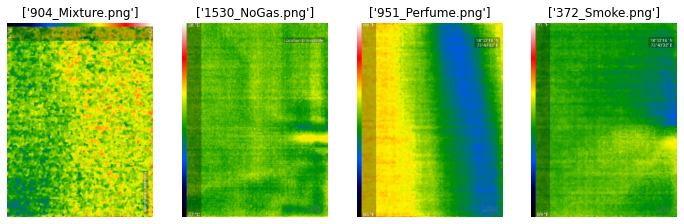

In [7]:
import matplotlib.pyplot as plt
examples = test_data.groupby('Gas').first()

# get the paths to the images
paths = examples['filepath']

# Create a figure with 4 subplots arranged in a row
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

# Iterate over the subplots and display each image
for i, path in enumerate(paths):
    # load image
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    
    # show image
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(path.split('/')[-1:])

# Show the figure
plt.show()

An example of the image data can be seen above. All images came in 480x640 resolution. Even though they may look similar, the color scale used in each image is different and show by by the color bar. The color bar marks the max and min temprature in the image. The model will have to lean to interpret the colors in the contect of the printed temperatures.

In [8]:
def create_generators(train_data, test_data, use_sensors, use_images):
    # define the output signature
    if use_sensors and use_images:
        output_signature=(
            {
                'image': tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
                'sensor': tf.TensorSpec(shape=(7,), dtype=tf.float32)
            },
            tf.TensorSpec(shape=(4,), dtype=tf.float32)
        )
    elif use_sensors:
        output_signature=(
            tf.TensorSpec(shape=(7,), dtype=tf.float32),
            tf.TensorSpec(shape=(4,), dtype=tf.float32)
        )
    elif use_images:
        output_signature=(
            tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(4,), dtype=tf.float32)
        )
    else:
        raise ValueError("Both use_sensors and use_images cannot be False")
    
    # Create the train dataset generator
    train_multimodal_gen = MultimodalDataset(train_data, use_sensors=use_sensors, use_images=use_images)
    val_multimodal_gen = MultimodalDataset(test_data, use_sensors=use_sensors, use_images=use_images)
    datasets = []
    
    # create the datasets and tune some settings
    for gen in [train_multimodal_gen, val_multimodal_gen]:
        dataset = tf.data.Dataset.from_generator(
            gen,
            output_signature=output_signature
        )

        dataset = dataset.batch(128)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        dataset = dataset.cache()
        
        datasets.append(dataset)

    
    return datasets[0], datasets[1]

This code turns the datasets into generators that can be used to train the model. The function returns both the training and testing generators.

## Train a general model (or per task model) to perform the classification tasks
*That is, a general model uses all modalities and all tasks should combined into a single classification task (if possible). Alternatively, if this is not possible, you could create a model for each specific task. For a task specific model, each task would be classified with its own feed-forward model.*

For the general classification I created three models. The first two use only the thermal camera and gas sensors, respectively. The third model uses both modalities but keeps only mixes them at the end. This is similar to getting output from the sepreate modality models and then having the network choose which one to use.

In [9]:
image_train_dataset, image_val_dataset = create_generators(train_data, test_data, use_sensors=False, use_images=True)

In [10]:
# create a simple CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
], name='image_only')

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

print(f"Number of trainable parameters: {model.count_params():,}")

Number of trainable parameters: 3,191,044


Epoch 1/40
40/40 [==============================] - 119s 3s/step - loss: 1.3822 - accuracy: 0.2951 - val_loss: 1.3424 - val_accuracy: 0.4047
Epoch 2/40
40/40 [==============================] - 23s 575ms/step - loss: 1.2263 - accuracy: 0.4905 - val_loss: 1.1901 - val_accuracy: 0.5102
Epoch 3/40
40/40 [==============================] - 23s 574ms/step - loss: 1.0628 - accuracy: 0.5636 - val_loss: 1.1536 - val_accuracy: 0.4773
Epoch 4/40
40/40 [==============================] - 23s 573ms/step - loss: 0.9298 - accuracy: 0.6127 - val_loss: 0.9260 - val_accuracy: 0.6883
Epoch 5/40
40/40 [==============================] - 23s 574ms/step - loss: 0.6929 - accuracy: 0.7201 - val_loss: 0.7326 - val_accuracy: 0.7563
Epoch 6/40
40/40 [==============================] - 23s 575ms/step - loss: 0.5108 - accuracy: 0.7916 - val_loss: 0.5710 - val_accuracy: 0.8133
Epoch 7/40
40/40 [==============================] - 23s 575ms/step - loss: 0.4046 - accuracy: 0.8370 - val_loss: 0.4922 - val_accuracy: 0.8367
E

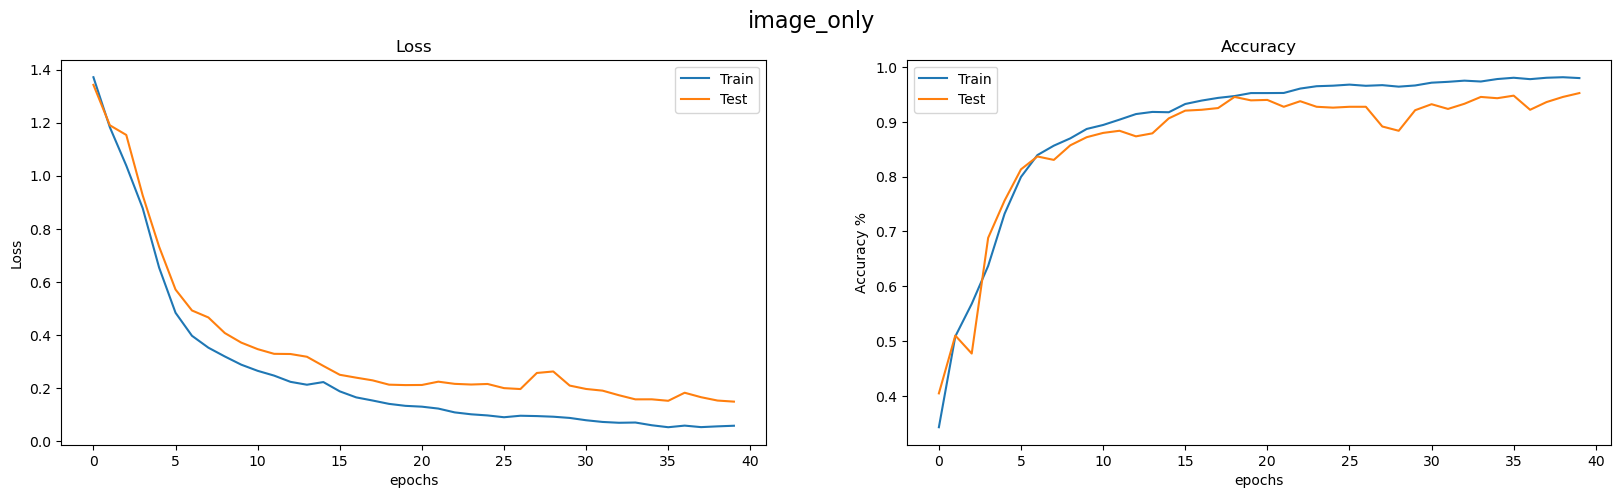

In [11]:
if USE_SAVED_MODELS:
    # load model
    model.load_weights(f"Models/{model.name}.h5")
    #load history
    with open(f"Models/{model.name}.pkl", 'rb') as file_pi:
        model.history = pickle.load(file_pi)

    print(f"Model {model.name} loaded")
    
    plot_history(model, model.name)
else:
    history = model.fit(image_train_dataset, validation_data=image_val_dataset, epochs=40, verbose=1)
    
    # save weights
    model.save_weights(f"Models/{model.name}.h5")
    
    # save history
    with open(f"Models/{model.name}.pkl", 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model {model.name} model saved")
    
    plot_history(history, model.name)
    
image_model = model

In [9]:
sensor_train_dataset, sensor_val_dataset = create_generators(train_data, test_data, use_sensors=True, use_images=False)

In [10]:
# create a simple MLP
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
], name='sensor_only')

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

print(f"Number of trainable parameters: {model.count_params():,}")

Number of trainable parameters: 6,884


/home/markbrub/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model sensor_only loaded


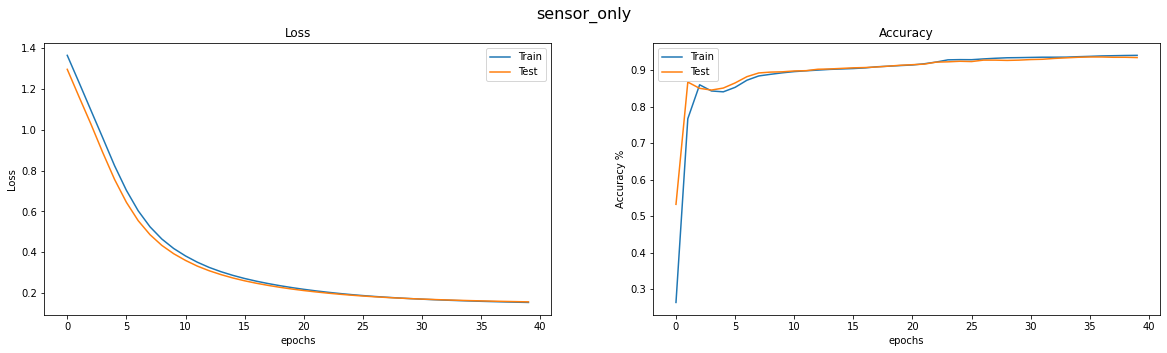

In [11]:
if USE_SAVED_MODELS:
    # load model
    model.load_weights(f"Models/{model.name}.h5")
    #load history
    with open(f"Models/{model.name}.pkl", 'rb') as file_pi:
        model.history = pickle.load(file_pi)

    print(f"Model {model.name} loaded")
    
    plot_history(model, model.name)
else:
    history = model.fit(sensor_train_dataset, validation_data=sensor_val_dataset, epochs=40, verbose=1)
    
    # save weights
    model.save_weights(f"Models/{model.name}.h5")
    
    # save history
    with open(f"Models/{model.name}.pkl", 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model {model.name} model saved")
    
    plot_history(history, model.name)
    
sensor_model = model

In [12]:
multimodal_train_dataset, multimodal_val_dataset = create_generators(train_data, test_data, use_sensors=True, use_images=True)

In [13]:
# create a functional multimodal CNN
image_input = tf.keras.Input(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), name='image')
sensor_input = tf.keras.Input(shape=(7,), name='sensor')

image = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.Dropout(.15)(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Flatten()(image)
image = tf.keras.layers.Dense(512, activation='relu')(image)
image = tf.keras.layers.Dense(64, activation='relu')(image)

sensor = tf.keras.layers.Dense(32, activation='relu')(sensor_input)
sensor = tf.keras.layers.Dense(32, activation='relu')(sensor)
sensor = tf.keras.layers.Dense(16, activation='relu')(sensor)

concat = tf.keras.layers.concatenate([image, sensor])
dense = tf.keras.layers.Dense(32, activation='relu')(concat)
output = tf.keras.layers.Dense(4, activation='softmax')(dense)

model = tf.keras.Model(inputs=[image_input, sensor_input], outputs=output, name='multimodal_late')

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

print(f"Number of trainable parameters: {model.count_params():,}")

Number of trainable parameters: 3,195,348


/home/markbrub/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model multimodal_late loaded


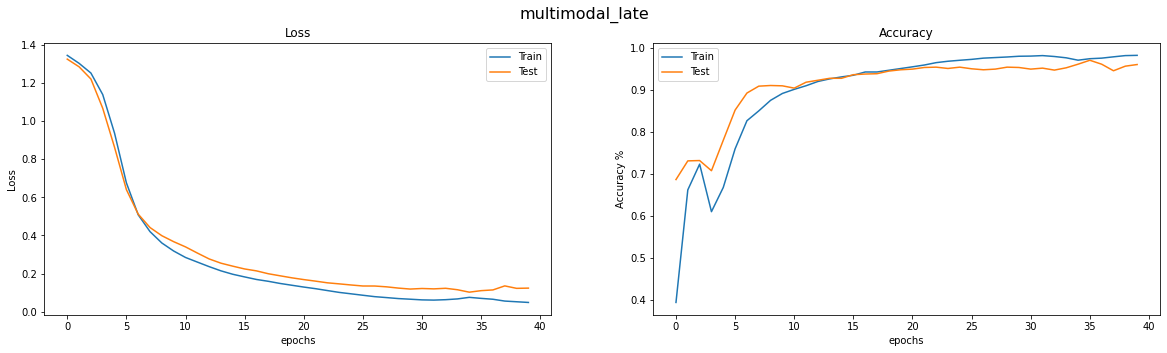

In [14]:
if USE_SAVED_MODELS:
    # load model
    model.load_weights(f"Models/{model.name}.h5")
    #load history
    with open(f"Models/{model.name}.pkl", 'rb') as file_pi:
        model.history = pickle.load(file_pi)

    print(f"Model {model.name} loaded")
    
    plot_history(model, model.name)
else:
    history = model.fit(multimodal_train_dataset, validation_data=multimodal_val_dataset, epochs=40, verbose=1)
    
    # save weights
    model.save_weights(f"Models/{model.name}.h5")
    
    # save history
    with open(f"Models/{model.name}.pkl", 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model {model.name} model saved")
    
    plot_history(history, model.name)
    
multimodal_late_model = model

## Train a multi-task model (and/or) multi-modal model
*You may use any method of multi-task or multi-modal training that you like.  For multi-task models, some fine tuning of the model should be attempted. For multi-modal models, some investigation of "where to merge" the modalities should be attempted. Be sure to look at the class demonstration example for code and hints. Feel free to use this code as a starting template.*

In order to further explore using both modalities in one model I created two more models that combine the data at different points. The first model combines the data at the input layer. I does this by expanding the sensor data to the same shape as the image data and then puts both throught the same convolutional layers. This counts on there being some relation between the sensor data and the image data. This would be expected in the dataset as the pressence of a specific gas has direct infuence to both modalitys. The second data combines the modalities after a few layers of processing before sendingthem through the rest of the CNN and dense layers. This model counts on the same relation between the modalities but assumes that the model will better be able to learn this relation after some preprocessing.

In [15]:
# create a functional multimodal CNN
image_input = tf.keras.Input(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), name='image')
sensor_input = tf.keras.Input(shape=(7,), name='sensor')

sensor_expanded = tf.expand_dims(sensor_input, axis=1)
sensor_expanded = tf.expand_dims(sensor_expanded, axis=1)
sensor_expanded = tf.tile(sensor_expanded, [1, IMAGE_LENGTH, IMAGE_WIDTH, 1])

x = tf.keras.layers.concatenate([image_input, sensor_expanded])
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=[image_input, sensor_input], outputs=output, name='multimodal_early')

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

print(f"Number of trainable parameters: {model.count_params():,}")

Number of trainable parameters: 3,193,060


Model multimodal_early loaded


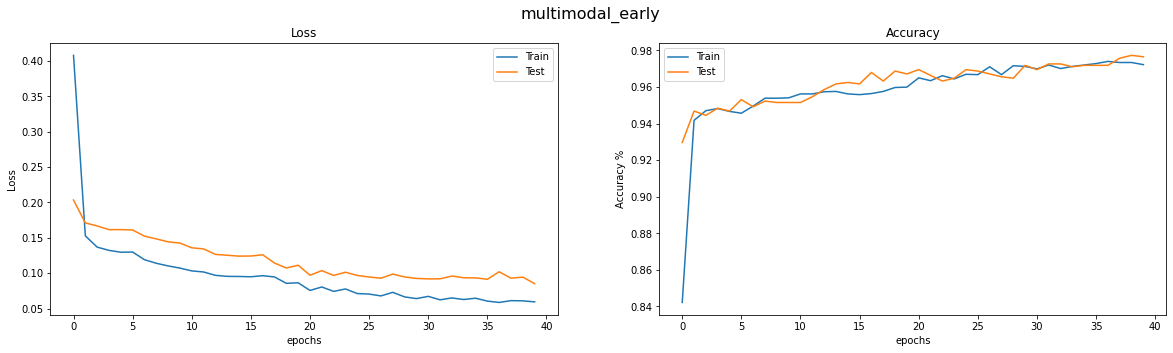

In [16]:
if USE_SAVED_MODELS:
    # load model
    model.load_weights(f"Models/{model.name}.h5")
    #load history
    with open(f"Models/{model.name}.pkl", 'rb') as file_pi:
        model.history = pickle.load(file_pi)

    print(f"Model {model.name} loaded")
    
    plot_history(model, model.name)
else:
    history = model.fit(multimodal_train_dataset, validation_data=multimodal_val_dataset, epochs=40, verbose=1)
    
    # save weights
    model.save_weights(f"Models/{model.name}.h5")
    
    # save history
    with open(f"Models/{model.name}.pkl", 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model {model.name} model saved")
    
    plot_history(history, model.name)
    
multimodal_early_model = model

In [17]:
# create a functional multimodal CNN
image_input = tf.keras.Input(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), name='image')
sensor_input = tf.keras.Input(shape=(7,), name='sensor')

sensor = tf.keras.layers.Dense(16, activation='relu')(sensor_input)
sensor = tf.keras.layers.Dense(32, activation='relu')(sensor)
sensor = tf.keras.layers.Dense(64, activation='relu')(sensor)

# expand to the dimension that will match the image after the first few layers
sensor_expanded = tf.expand_dims(sensor, axis=1)
sensor_expanded = tf.expand_dims(sensor_expanded, axis=1)
sensor_expanded = tf.tile(sensor_expanded, [1, 158, 118, 1])

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.concatenate([x, sensor_expanded])

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(.15)(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=[image_input, sensor_input], outputs=output, name='multimodal_mid')

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

print(f"Number of trainable parameters: {model.count_params():,}")

Number of trainable parameters: 3,267,556


Model multimodal_mid loaded


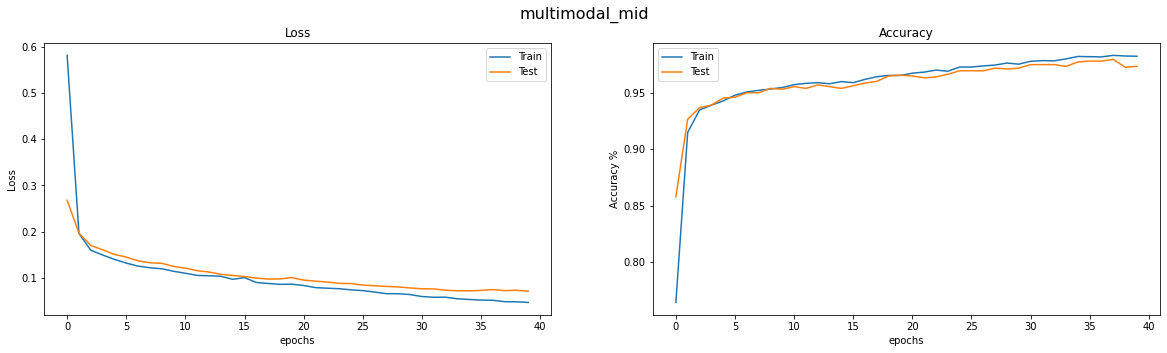

In [18]:
if USE_SAVED_MODELS:
    # load model
    model.load_weights(f"Models/{model.name}.h5")
    #load history
    with open(f"Models/{model.name}.pkl", 'rb') as file_pi:
        model.history = pickle.load(file_pi)

    print(f"Model {model.name} loaded")
    
    plot_history(model, model.name)
else:
    history = model.fit(multimodal_train_dataset, validation_data=multimodal_val_dataset, epochs=40, verbose=1)
    
    # save weights
    model.save_weights(f"Models/{model.name}.h5")
    
    # save history
    with open(f"Models/{model.name}.pkl", 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Model {model.name} model saved")
    
    plot_history(history, model.name)
    
multimodal_mid_model = model

## Report the results using the evaluation procedure that you argued for at the beginning of the lab.
*Compare the general/personal model to your best multi-modal/multi-task model. Results should be reported with proper statistical comparisons and proper visualizations.*